In [2]:
# Required libraries
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
korea_df = pd.read_csv("/Users/youngbeomcho/Desktop/Young Beom Cho/UST/22-23 Spring/SOSC 4110/Data/korea_dataset.csv", index_col= 0)
korea_df.head()

,GDP_growth,Inflation_change,Debt_change,LeftRulingParty,RightRulingParty,NuclearExperiment,MissileThreat,EngageinBattle,MS_change
1960,0.000000,0.000000,0.0,1,0,0,0,0,0.000000
1961,-0.637476,0.000000,0.0,1,0,0,0,0,-0.755006
1962,0.141045,0.227909,0.0,1,0,0,0,0,0.156282
1963,0.294311,0.442637,0.0,0,1,0,0,0,-0.004149
1964,-0.153061,0.009815,0.0,0,1,0,0,0,-0.348433


In [69]:
test = korea_df[32:62]

In [ ]:
test_list =[0.03614982, 0.03614982, 0.03614982, 0.03614982, 0.03614982, 0.03614982,
 0.03614982, 0.03614982, 0.03614982, 0.03614982, 0.03614982, 0.03614982,
 0.03614982, 0.03614982, 0.03614982, 0.03614982, 0.03614982, 0.03614982,
 0.03614982, 0.03614982, 0.03614982, 0.03614982, 0.03614982, 0.03614982,
 0.03614982, 0.02705778, 0.03614982, 0.03614982, 0.03614982, 0.03614982,
 0.03614982, 0.03614982, 0.03614982, 0.02705778, 0.03614982, 0.03614982,
 0.02705778, 0.03614982, 0.03614982, 0.02705778, 0.02705778, 0.02705778,
 0.02705778, 0.02705778, 0.02705778, 0.03614982, 0.02705778, 0.02705778,
 0.02705778,]

print(sum(test_list))
print(len(test_list))
print(sum(test_list)/ len(test_list))

In [70]:
from collections import Counter


print(Counter(test_list).keys()) # equals to list(set(words))
print(Counter(test_list).values()) # counts the elements' frequency

dict_keys([0.03614982, 0.02705778])
dict_values([37, 12])


In [71]:
test_missile = test.MissileThreat.to_list()
print(Counter(test_missile).keys()) # equals to list(set(words))
print(Counter(test_missile).values()) # counts the elements' frequency

dict_keys([0, 1])
dict_values([18, 12])


In [72]:
test_nuclear = test.NuclearExperiment.to_list()
print(Counter(test_nuclear).keys()) # equals to list(set(words))
print(Counter(test_nuclear).values()) # counts the elements' frequency

dict_keys([0, 1])
dict_values([25, 5])


In [73]:
test_left = test.LeftRulingParty.to_list()
print(Counter(test_left).keys()) # equals to list(set(words))
print(Counter(test_left).values()) # counts the elements' frequency

dict_keys([0, 1])
dict_values([15, 15])


## T = LeftRulingParty, X = MissileThreat

### Param

In [74]:
# Define estimator inputs (X = MissileThreat)
Y = test["MS_change"].values
T = test["LeftRulingParty"].values
X = test[["MissileThreat"]].values  # features
confounder_names = ["GDP_growth", "EngageinBattle"]
W = test[confounder_names].values

In [75]:
# initiate an EconML cate estimator
estL1 = LinearDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

In [76]:
estL1_dw = estL1.dowhy.fit(Y, T, X=X, W=W, outcome_names=["MS_change"], treatment_names=["LeftRulingParty"], feature_names=["MissileThreat"],
               confounder_names=confounder_names, inference="statsmodels")

Co-variance matrix is underdetermined. Inference will be invalid!


nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723


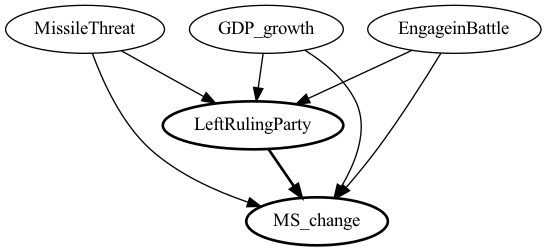

In [77]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(estL1_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    estL1_dw.view_model() 

In [78]:
identified_estimand = estL1_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                               
──────────────────(E[MS_change|GDP_growth,MissileThreat,EngageinBattle])
d[LeftRulingParty]                                                      
Estimand assumption 1, Unconfoundedness: If U→{LeftRulingParty} and U→MS_change then P(MS_change|LeftRulingParty,GDP_growth,MissileThreat,EngageinBattle,U) = P(MS_change|LeftRulingParty,GDP_growth,MissileThreat,EngageinBattle)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [79]:
lineardml_estimate = estL1_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                               
──────────────────(E[MS_change|GDP_growth,MissileThreat,EngageinBattle])
d[LeftRulingParty]                                                      
Estimand assumption 1, Unconfoundedness: If U→{LeftRulingParty} and U→MS_change then P(MS_change|LeftRulingParty,GDP_growth,MissileThreat,EngageinBattle,U) = P(MS_change|LeftRulingParty,GDP_growth,MissileThreat,EngageinBattle)

## Realized estimand
b: MS_change~LeftRulingParty+GDP_growth+MissileThreat+EngageinBattle | MissileThreat
Target units: ate

## Estimate
Mean value: 0.021322640967072346
Effect estimates: [0.01786379 0.01786379 0.01786379 0.01786379 0.01786379 0.01786379
 0.02651092 0.01786379 0.01786379 0.01786379 0.01786379 0.01786379
 0.01786379 0.01786379 0.02651092 0.01786379 0.01786379 0.02651092
 0.01786379 0.017863

### Non-Param

In [80]:
# initiate an EconML cate estimator
estL1_nonparam = CausalForestDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor())
# fit through dowhy
estL1_nonparam_dw = estL1_nonparam.dowhy.fit(Y, T, X=X, W=W, outcome_names=["MS_change"], treatment_names=["LeftRulingParty"],
                                         feature_names=["MissileThreat"], confounder_names=confounder_names, inference="blb")

In [81]:
print(estL1_nonparam_dw.estimate_)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                               
──────────────────(E[MS_change|GDP_growth,MissileThreat,EngageinBattle])
d[LeftRulingParty]                                                      
Estimand assumption 1, Unconfoundedness: If U→{LeftRulingParty} and U→MS_change then P(MS_change|LeftRulingParty,GDP_growth,MissileThreat,EngageinBattle,U) = P(MS_change|LeftRulingParty,GDP_growth,MissileThreat,EngageinBattle)

## Realized estimand
b: MS_change~LeftRulingParty+GDP_growth+MissileThreat+EngageinBattle | MissileThreat
Target units: ate

## Estimate
Mean value: -0.004945148452564918
Effect estimates: [-0.00494515 -0.00494515 -0.00494515 -0.00494515 -0.00494515 -0.00494515
 -0.00494515 -0.00494515 -0.00494515 -0.00494515 -0.00494515 -0.00494515
 -0.00494515 -0.00494515 -0.00494515 -0.00494515 -0.00494515 -0.00494515
 

In [82]:
res_random = estL1_nonparam_dw.refute_estimate(method_name="random_common_cause", num_simulations=4)
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.004945148452564918
New effect:0.0182736475834967
p value:0.0009664003646650323



In [83]:
res_unobserved = estL1_nonparam_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.004945148452564918
New effect:-0.05354853703509185



In [84]:
res_placebo = estL1_nonparam_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.004945148452564918
New effect:0.018358030574795934
p value:0.14865273878892765



In [85]:
res_subset = estL1_nonparam_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.2, 
    num_simulations=3)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.004945148452564918
New effect:0.013991865986492463
p value:0.15692181770306318



## T = LeftRulingParty, T = NuclearExperiment

### Param

In [86]:
# Define estimator inputs (T = LeftRulingParty)
Y = test["MS_change"].values
T = test["LeftRulingParty"].values
X = test[["NuclearExperiment"]].values  # features
confounder_names = ["GDP_growth", "EngageinBattle"]
W = test[confounder_names].values

In [87]:
# initiate an EconML cate estimator
estL2 = LinearDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

In [88]:
estL2_dw = estL2.dowhy.fit(Y, T, X=X, W=W, outcome_names=["MS_change"], treatment_names=["LeftRulingParty"], feature_names=["NuclearExperiment"],
               confounder_names=confounder_names, inference="statsmodels")

Co-variance matrix is underdetermined. Inference will be invalid!


nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723


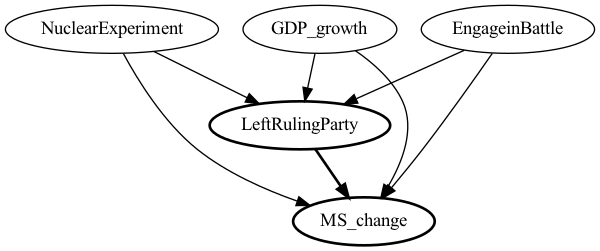

In [89]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(estL2_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    estL2_dw.view_model() 

In [90]:
identified_estimand = estL2_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                   
──────────────────(E[MS_change|NuclearExperiment,GDP_growth,EngageinBattle])
d[LeftRulingParty]                                                          
Estimand assumption 1, Unconfoundedness: If U→{LeftRulingParty} and U→MS_change then P(MS_change|LeftRulingParty,NuclearExperiment,GDP_growth,EngageinBattle,U) = P(MS_change|LeftRulingParty,NuclearExperiment,GDP_growth,EngageinBattle)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [91]:
test

,GDP_growth,Inflation_change,Debt_change,LeftRulingParty,RightRulingParty,NuclearExperiment,MissileThreat,EngageinBattle,MS_change
1992,0.069972,-0.175248,0.000000,0,1,0,0,0,0.056665
1993,0.094586,-0.243574,0.000000,0,1,0,0,0,0.061625
1994,0.153038,0.233417,1.000000,0,1,0,0,0,0.084460
1995,0.181731,-0.161490,0.258035,0,1,0,0,0,0.159516
1996,0.071433,-0.708859,0.247928,0,1,0,0,1,0.019719
1997,-0.070934,-0.026825,0.103960,0,1,0,0,1,-0.105073
1998,-0.486326,0.105596,-0.065963,1,0,0,1,0,-0.419826
1999,0.229505,4.639449,-0.084406,1,0,0,0,1,0.135362
2000,0.136530,2.203638,-0.034024,1,0,0,0,0,0.123607
2001,-0.052076,0.706263,-0.165517,1,0,0,0,0,-0.066394


In [92]:
lineardml_estimate = estL2_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                   
──────────────────(E[MS_change|NuclearExperiment,GDP_growth,EngageinBattle])
d[LeftRulingParty]                                                          
Estimand assumption 1, Unconfoundedness: If U→{LeftRulingParty} and U→MS_change then P(MS_change|LeftRulingParty,NuclearExperiment,GDP_growth,EngageinBattle,U) = P(MS_change|LeftRulingParty,NuclearExperiment,GDP_growth,EngageinBattle)

## Realized estimand
b: MS_change~LeftRulingParty+NuclearExperiment+GDP_growth+EngageinBattle | NuclearExperiment
Target units: ate

## Estimate
Mean value: 0.04237075382318993
Effect estimates: [0.04765169 0.04765169 0.04765169 0.04765169 0.04765169 0.04765169
 0.04765169 0.04765169 0.04765169 0.04765169 0.04765169 0.04765169
 0.04765169 0.04765169 0.01596608 0.04765169 0.04765169 0.01

### Non-param

In [93]:
# initiate an EconML cate estimator
estL2_nonparam = CausalForestDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor())
# fit through dowhy
estL2_nonparam_dw = estL2_nonparam.dowhy.fit(Y, T, X=X, W=W, outcome_names=["MS_change"], treatment_names=["LeftRulingParty"],
                                         feature_names=["NuclearExperiment"], confounder_names=confounder_names, inference="blb")

In [94]:
print(estL2_nonparam_dw.estimate_)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                   
──────────────────(E[MS_change|NuclearExperiment,GDP_growth,EngageinBattle])
d[LeftRulingParty]                                                          
Estimand assumption 1, Unconfoundedness: If U→{LeftRulingParty} and U→MS_change then P(MS_change|LeftRulingParty,NuclearExperiment,GDP_growth,EngageinBattle,U) = P(MS_change|LeftRulingParty,NuclearExperiment,GDP_growth,EngageinBattle)

## Realized estimand
b: MS_change~LeftRulingParty+NuclearExperiment+GDP_growth+EngageinBattle | NuclearExperiment
Target units: ate

## Estimate
Mean value: 0.028814802964950908
Effect estimates: [0.0288148 0.0288148 0.0288148 0.0288148 0.0288148 0.0288148 0.0288148
 0.0288148 0.0288148 0.0288148 0.0288148 0.0288148 0.0288148 0.0288148
 0.0288148 0.0288148 0.0288148 0.0288148 0.0288148 

In [95]:
res_random = estL2_nonparam_dw.refute_estimate(method_name="random_common_cause", num_simulations=5)
print(res_random)

Refute: Add a random common cause
Estimated effect:0.028814802964950908
New effect:-0.004559887426019296
p value:0.02240341991739314



In [96]:
res_unobserved = estL2_nonparam_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:0.028814802964950908
New effect:-0.05017547101139484



In [97]:
res_placebo = estL2_nonparam_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.028814802964950908
New effect:0.023693216677271353
p value:3.55112079944736e-24



In [98]:
res_subset = estL2_nonparam_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

Refute: Use a subset of data
Estimated effect:0.028814802964950908
New effect:0.005040661374949517
p value:0.0816649166628809



## T = RightRulingParty, X = MissileThreat

### Param

In [99]:
# Define estimator inputs (X = MissileThreat)
Y = test["MS_change"].values
T = test["RightRulingParty"].values
X = test[["MissileThreat"]].values  # features
confounder_names = ["GDP_growth", "EngageinBattle"]
W = test[confounder_names].values

In [100]:
estR1 = LinearDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

In [101]:
estR1_dw = estR1.dowhy.fit(Y, T, X=X, W=W, outcome_names=["MS_change"], treatment_names=["RightRulingParty"], feature_names=["MissileThreat"],
               confounder_names=confounder_names, inference="statsmodels")

Co-variance matrix is underdetermined. Inference will be invalid!


nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723


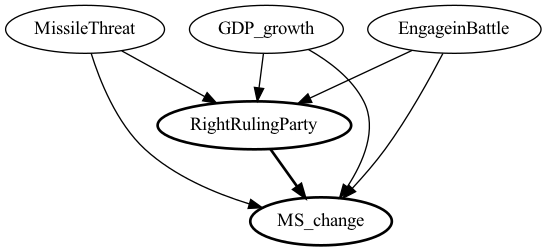

In [102]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(estR1_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    estR1_dw.view_model() 

In [103]:
identified_estimand = estR1_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                               
───────────────────(E[MS_change|GDP_growth,MissileThreat,EngageinBattle])
d[RightRulingParty]                                                      
Estimand assumption 1, Unconfoundedness: If U→{RightRulingParty} and U→MS_change then P(MS_change|RightRulingParty,GDP_growth,MissileThreat,EngageinBattle,U) = P(MS_change|RightRulingParty,GDP_growth,MissileThreat,EngageinBattle)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [104]:
lineardml_estimate = estR1_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                               
───────────────────(E[MS_change|GDP_growth,MissileThreat,EngageinBattle])
d[RightRulingParty]                                                      
Estimand assumption 1, Unconfoundedness: If U→{RightRulingParty} and U→MS_change then P(MS_change|RightRulingParty,GDP_growth,MissileThreat,EngageinBattle,U) = P(MS_change|RightRulingParty,GDP_growth,MissileThreat,EngageinBattle)

## Realized estimand
b: MS_change~RightRulingParty+GDP_growth+MissileThreat+EngageinBattle | MissileThreat
Target units: ate

## Estimate
Mean value: -0.020743594363152193
Effect estimates: [-0.01615552 -0.01615552 -0.01615552 -0.01615552 -0.01615552 -0.01615552
 -0.0276257  -0.01615552 -0.01615552 -0.01615552 -0.01615552 -0.01615552
 -0.01615552 -0.01615552 -0.0276257  -0.01615552 -0.01615552 -0.027

### Non-param

In [105]:
# initiate an EconML cate estimator
estR1_nonparam = CausalForestDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor())
# fit through dowhy
estR1_nonparam_dw = estR1_nonparam.dowhy.fit(Y, T, X=X, W=W, outcome_names=["MS_change"], treatment_names=["RightRulingParty"],
                                         feature_names=["MissileThreat"], confounder_names=confounder_names, inference="blb")

In [106]:
print(estR1_nonparam_dw.estimate_)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                               
───────────────────(E[MS_change|GDP_growth,MissileThreat,EngageinBattle])
d[RightRulingParty]                                                      
Estimand assumption 1, Unconfoundedness: If U→{RightRulingParty} and U→MS_change then P(MS_change|RightRulingParty,GDP_growth,MissileThreat,EngageinBattle,U) = P(MS_change|RightRulingParty,GDP_growth,MissileThreat,EngageinBattle)

## Realized estimand
b: MS_change~RightRulingParty+GDP_growth+MissileThreat+EngageinBattle | MissileThreat
Target units: ate

## Estimate
Mean value: -0.006559085404062168
Effect estimates: [-0.00655909 -0.00655909 -0.00655909 -0.00655909 -0.00655909 -0.00655909
 -0.00655909 -0.00655909 -0.00655909 -0.00655909 -0.00655909 -0.00655909
 -0.00655909 -0.00655909 -0.00655909 -0.00655909 -0.00655909 -0.006

In [107]:
res_random = estR1_nonparam_dw.refute_estimate(method_name="random_common_cause", num_simulations=5)
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.006559085404062168
New effect:-0.003790086150394113
p value:0.44977801785047977



In [108]:
res_unobserved = estR1_nonparam_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.006559085404062168
New effect:-0.12003675981444063



In [109]:
res_placebo = estR1_nonparam_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.006559085404062168
New effect:0.022716076591484325
p value:0.04678777259914794



In [110]:
res_subset = estR1_nonparam_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.2, 
    num_simulations=5)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.006559085404062168
New effect:-0.04731168556314537
p value:0.04091349263050059



## T = RightRulingParty, F = NuclearExperiment

### Param

In [111]:
# Define estimator inputs (T = LeftRulingParty)
Y = test["MS_change"].values
T = test["RightRulingParty"].values
X = test[["NuclearExperiment"]].values  # features
confounder_names = ["GDP_growth", "EngageinBattle"]
W = test[confounder_names].values

In [112]:
# initiate an EconML cate estimator
estR2 = LinearDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

In [113]:
estR2_dw = estL2.dowhy.fit(Y, T, X=X, W=W, outcome_names=["MS_change"], treatment_names=["RightRulingParty"], feature_names=["NuclearExperiment"],
               confounder_names=confounder_names, inference="statsmodels")

Co-variance matrix is underdetermined. Inference will be invalid!


nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723


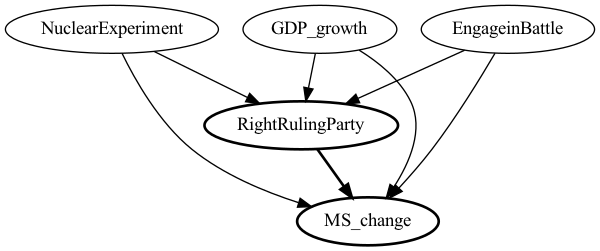

In [114]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(estR2_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    estR2_dw.view_model() 

In [115]:
identified_estimand = estR2_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                   
───────────────────(E[MS_change|NuclearExperiment,GDP_growth,EngageinBattle])
d[RightRulingParty]                                                          
Estimand assumption 1, Unconfoundedness: If U→{RightRulingParty} and U→MS_change then P(MS_change|RightRulingParty,NuclearExperiment,GDP_growth,EngageinBattle,U) = P(MS_change|RightRulingParty,NuclearExperiment,GDP_growth,EngageinBattle)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [116]:
lineardml_estimate = estR2_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                   
───────────────────(E[MS_change|NuclearExperiment,GDP_growth,EngageinBattle])
d[RightRulingParty]                                                          
Estimand assumption 1, Unconfoundedness: If U→{RightRulingParty} and U→MS_change then P(MS_change|RightRulingParty,NuclearExperiment,GDP_growth,EngageinBattle,U) = P(MS_change|RightRulingParty,NuclearExperiment,GDP_growth,EngageinBattle)

## Realized estimand
b: MS_change~RightRulingParty+NuclearExperiment+GDP_growth+EngageinBattle | NuclearExperiment
Target units: ate

## Estimate
Mean value: -0.019626761891211354
Effect estimates: [-0.0185073  -0.0185073  -0.0185073  -0.0185073  -0.0185073  -0.0185073
 -0.0185073  -0.0185073  -0.0185073  -0.0185073  -0.0185073  -0.0185073
 -0.0185073  -0.0185073  -0.02522409 -0.0

### Non-param

In [117]:
# initiate an EconML cate estimator
estR2_nonparam = CausalForestDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor())
# fit through dowhy
estR2_nonparam_dw = estR2_nonparam.dowhy.fit(Y, T, X=X, W=W, outcome_names=["MS_change"], treatment_names=["RightRulingParty"],
                                         feature_names=["NuclearExperiment"], confounder_names=confounder_names, inference="blb")

In [118]:
print(estR2_nonparam_dw.estimate_)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                   
───────────────────(E[MS_change|NuclearExperiment,GDP_growth,EngageinBattle])
d[RightRulingParty]                                                          
Estimand assumption 1, Unconfoundedness: If U→{RightRulingParty} and U→MS_change then P(MS_change|RightRulingParty,NuclearExperiment,GDP_growth,EngageinBattle,U) = P(MS_change|RightRulingParty,NuclearExperiment,GDP_growth,EngageinBattle)

## Realized estimand
b: MS_change~RightRulingParty+NuclearExperiment+GDP_growth+EngageinBattle | NuclearExperiment
Target units: ate

## Estimate
Mean value: -0.017261358547572873
Effect estimates: [-0.01726136 -0.01726136 -0.01726136 -0.01726136 -0.01726136 -0.01726136
 -0.01726136 -0.01726136 -0.01726136 -0.01726136 -0.01726136 -0.01726136
 -0.01726136 -0.01726136 -0.01726136 -0

In [119]:
res_random = estR2_nonparam_dw.refute_estimate(method_name="random_common_cause", num_simulations=5)
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.017261358547572873
New effect:-0.006662904906431148
p value:0.22813871806168168



In [120]:
res_unobserved = estR2_nonparam_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.017261358547572873
New effect:0.010717508539528527



In [121]:
res_placebo = estR2_nonparam_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.017261358547572873
New effect:-0.0026699501750230546
p value:0.4558334034096192



In [122]:
res_subset = estR2_nonparam_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.017261358547572873
New effect:-0.01437855478100416
p value:0.40939093456838593

